# Synthetic Example with One Artificial Outlier

In [1]:
from itertools import chain
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import constants
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from util import lexsort_rows
from util.drawing import plot_local_outlier_factor, plot_network, plot_isolation_forest
from util.graph import edges_on_path, random_graph
from util.incidence import create_node_edge_incidence_matrix, create_triangle_list, create_edge_triangle_incidence_matrix
from util.trajectory import full_trajectory_matrix, flatten_trajectory_matrix, create_matrix_coordinates_trajectory_Hspace, harmonic_projection_matrix, random_trajectory_class

## Config

In [2]:
# graph parameters
number_points = 1000
number_holes = 2

# trajectory parameters
num_trajectory_classes = 3
num_trajectories_per_class = 34
num_outliers = 1

# plots
sns.set_theme()
trajectory_color_palette = sns.color_palette('tab10', n_colors=num_trajectory_classes + num_outliers)
sns.set_palette(trajectory_color_palette)
storage_dir = Path('.') / 'cache' / 'proof_of_concept'

# reproducibility
random_state = np.random.RandomState(2**9) # 110, 234, 12345678, 987654321, 2**9

## Setup

### Graph Construction

In [3]:
graph, node_positions, holes, hole_centers = random_graph(number_points, number_holes, seed=random_state)

elist = np.array(graph.edges())
elist = lexsort_rows(elist)
elist_dict = {(j[0], j[1]): i for i, j in enumerate(graph.edges())}

### Random Trajectories

In [4]:
trajectory_classes = []
existing_locations = []

for _ in range(num_trajectory_classes):
    departure_point, arrival_point, trajectories = random_trajectory_class(graph, node_positions, num_trajectories_per_class, existing_locations=existing_locations, seed=random_state)
    existing_locations.append((departure_point, arrival_point))
    trajectory_classes.append(trajectories)

for _ in range(num_outliers):
        departure_point, arrival_point, trajectories = random_trajectory_class(graph, node_positions, 1, existing_locations=existing_locations, seed=random_state)
        existing_locations.append((departure_point, arrival_point))
        trajectory_classes.append(trajectories)

## Projection

In [5]:
B1 = create_node_edge_incidence_matrix(elist)

tlist = create_triangle_list(graph)
B2 = create_edge_triangle_incidence_matrix(elist, tlist)

L1 = (B1.T @ B1 + B2 @ B2.T)

In [6]:
M_full = full_trajectory_matrix(graph, map(lambda path: list(edges_on_path(path)), chain.from_iterable(trajectory_classes)), elist, elist_dict)
M_flatten = flatten_trajectory_matrix(M_full)

H = harmonic_projection_matrix(L1.astype(float), number_holes)

In [7]:
mat_coord_Hspace = create_matrix_coordinates_trajectory_Hspace(H, M_full)
mat_coor_flatten_trajectory = [H @ mat for mat in M_flatten]

### Plot of Setup

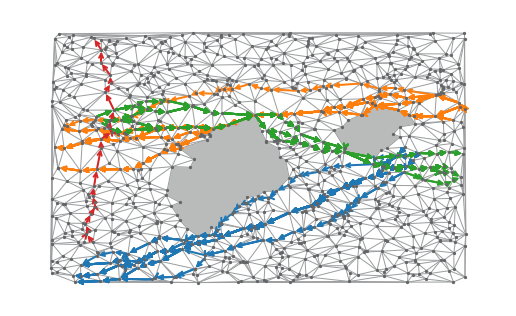

In [8]:
fig_width = 9

fig, ax = plt.subplots(figsize=(fig_width, fig_width / constants.golden))
plot_network(graph, node_positions, holes, trajectory_classes, ax=ax)
fig.savefig(storage_dir / 'network.pdf', bbox_inches='tight')

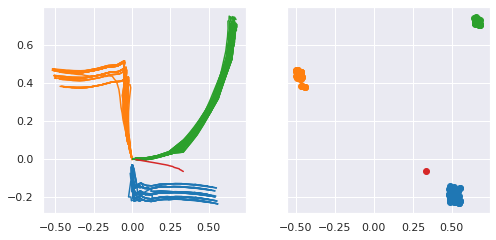

In [9]:
figsize = 8
fig, axes = plt.subplots(ncols=2, figsize=(figsize, figsize / 2 - 0.2), sharey=True)

cumsums = list(map(lambda i: [np.cumsum(i[0]), np.cumsum(i[1])], mat_coord_Hspace))
for i, cumsum in enumerate(cumsums):
    color = trajectory_color_palette[i // num_trajectories_per_class]
    sns.lineplot(x=cumsum[0], y=cumsum[1], color=color, ax=axes[0], sort=False)

for count, i in enumerate(range(len(mat_coor_flatten_trajectory))):
    color = trajectory_color_palette[count // num_trajectories_per_class]
    axes[1].scatter(mat_coor_flatten_trajectory[i][0], mat_coor_flatten_trajectory[i][1], color=color)

fig.savefig(storage_dir / 'embeddings.pdf', bbox_inches='tight')

## Classification of Outliers

In [10]:
mat_coor = []
for i in mat_coor_flatten_trajectory:
    mat_coor.append(i.tolist())
mat_coor = np.array(mat_coor)

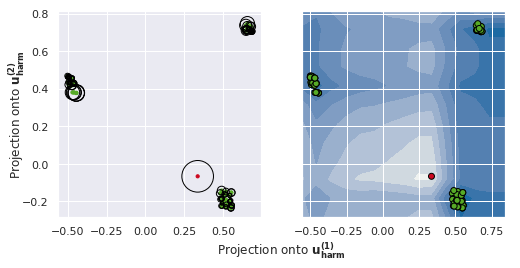

In [11]:
figsize = 8
fig, axes = plt.subplots(ncols=2, figsize=(figsize, figsize / 2 - 0.2), sharey=True)

contamination_factor = num_outliers / (num_trajectory_classes * num_trajectories_per_class + num_outliers)
local_outlier_factor = LocalOutlierFactor(contamination=contamination_factor)
isolation_forest = IsolationForest(contamination=contamination_factor)

plot_local_outlier_factor(local_outlier_factor, mat_coor, ax=axes[0])
plot_isolation_forest(isolation_forest, mat_coor, ax=axes[1])

ax = fig.add_subplot(111, frame_on=False)
ax.tick_params(labelcolor="none", bottom=False, left=False)
ax.grid(False)
ax.set_xlabel(r'Projection onto $\mathbf{u_{harm}^{(1)}}$')
ax.set_ylabel(r'Projection onto $\mathbf{u_{harm}^{(2)}}$')

fig.savefig(storage_dir / 'outlier_predictions.pdf', bbox_inches='tight')